In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate
import plotly.graph_objects as go

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output,State



sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)

# Data set cleaned for Covid-19 modelling

the file COVED_small_flat_table has to be generated via the NOTEBOOK DATA PREPARATION

Goal of the exercise a dynamic dashboard of the last cell in the notebook, where one can select the fit for different countries

Fit of SIR model for Germany cases

In [2]:
# try to parse the dates right at the beginning 
# it works out of the box if the date was stored ISO YYYY-MM-DD format


df_analyse=pd.read_csv(r"D:\SEM 4\Data Science\ads_covid-19\data\processed\COVID_small_flat_table.csv",sep=';')  
df_analyse.sort_values('date',ascending=True)

,date,Italy,US,Spain,Germany,"Korea, South"
0,2020-01-22,0,1,0,0,1
1,2020-01-23,0,1,0,0,1
2,2020-01-24,0,2,0,0,2
3,2020-01-25,0,2,0,0,2
4,2020-01-26,0,5,0,0,3
...,...,...,...,...,...,...
909,2022-07-19,20299013,89830497,13132159,29994679,18937971
910,2022-07-20,20385814,90046261,13132159,30131303,19009080
911,2022-07-21,20467349,90200438,13132159,30239122,19077659
912,2022-07-22,20539016,90367064,13204863,30331131,19146180


In [3]:
# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=1000000 #max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate

## beta/gamma is the basic reproduction number, <1 means no spread virus


# condition I0+S0+R0=N0
I0=df_analyse.Germany[35]
S0=N0-I0
R0=0

In [4]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])

# Simulative approach to calculate SIR curves

In [5]:
SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

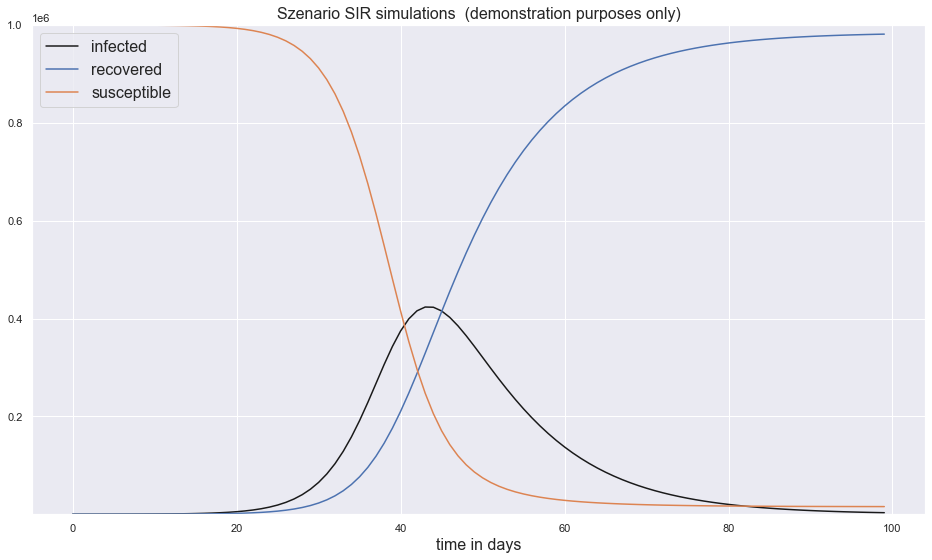

In [6]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

# Fitting data to a model

## step one: always start on simulative / constructive data

Goal is to fit a data model (SIR) model to obtain the parameters beta and gamma

step one: always start on simulative / constructive data step two: cross check if the innerlogic of your parameter fitting is correct

In [7]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [8]:
# the resulting curve has to be fitted
# free parameters are here beta and gamma

def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [9]:
## fit the data set ydata, here the simulative data set of the infected curve

ydata = propagation_rates.infected
t=np.arange(len(ydata))

In [10]:
#ydata

In [11]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

<ipython-input-7-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-7-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-7-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


standard deviation errors :  [0.00087012 0.00074077]  start infect: 27.299823600000003
Optimal parameters: beta = 0.37337789054916876  and gamma =  0.09619940540430044


In [12]:
# get the final fitted curve
fitted=fit_odeint(t, *popt)

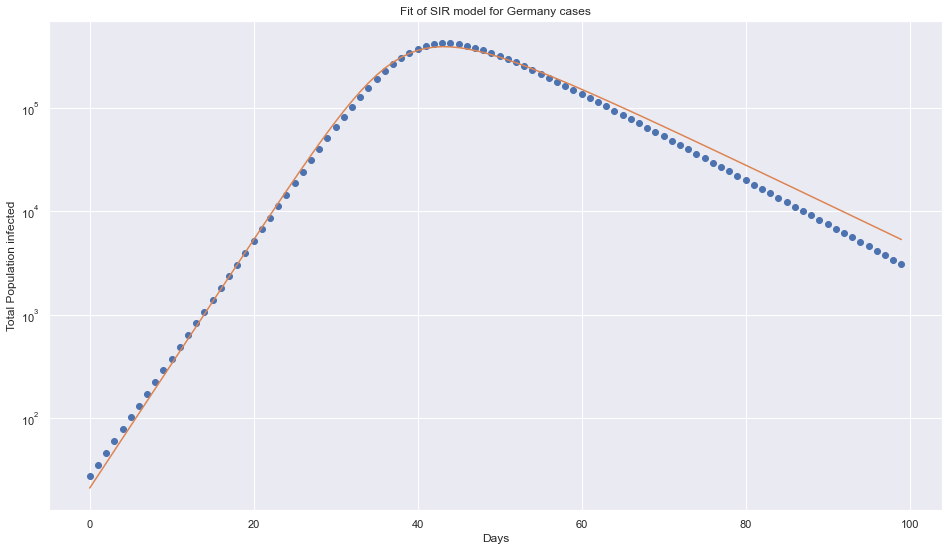

Optimal parameters: beta = 0.37337789054916876  and gamma =  0.09619940540430044
Basic Reproduction Number R0  3.8812910431198726
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [13]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
#plt.semilogy(fitted)

plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Total Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")


# Fitting the parameters of SIR model

the SIR model is assuming a very simplistic curve however we can find situations (time windows) where the model might apply

In [14]:
df_analyse.Germany[40::]

40          150
41          188
42          240
43          349
44          534
         ...   
909    29994679
910    30131303
911    30239122
912    30331131
913    30331133
Name: Germany, Length: 874, dtype: int64

In [15]:
## slice out some true data of a country

ydata = np.array(df_analyse.Germany[40:400])
t=np.arange(len(ydata))

In [16]:
# ensure re-initialization 
# attenion when slicing gout only a time window 
# (one Corana wave) the overall N0 is not the full popoulation size 
N0=80000000

I0=ydata[0]
S0=N0-I0
R0=0
print('start infected:',I0)
print('cumulative sum of invected after period',ydata[-1])
print('Number of days',len(ydata))
print('N0',N0)

start infected: 150
cumulative sum of invected after period 2402818
Number of days 360
N0 80000000


In [17]:
## get the model parameters / fit the model
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

# get the final fitted curve / predict the outcome 
fitted=fit_odeint(t, *popt)

C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


standard deviation errors :  [4.52308321 4.51786125]  start infect: 150
Optimal parameters: beta = 1.0037893267739464  and gamma =  0.9792541383835438


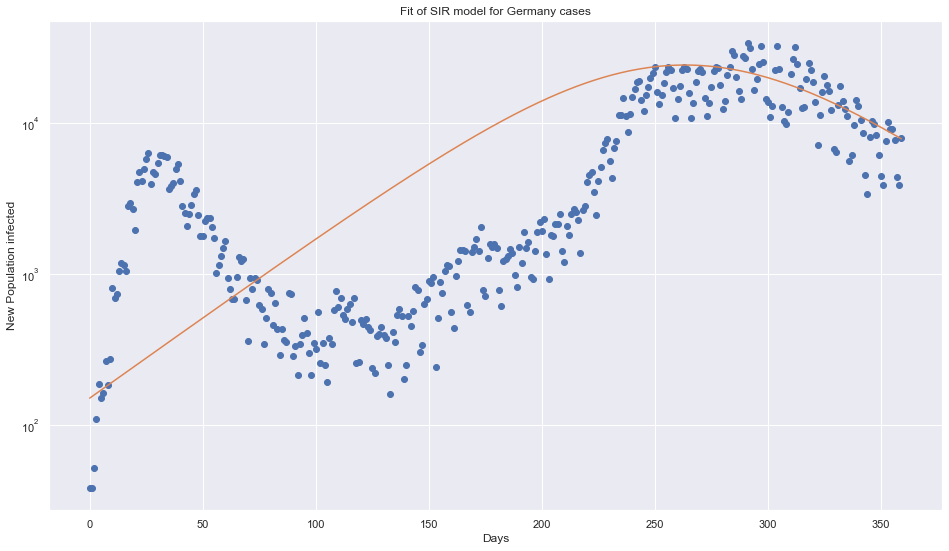

Optimal parameters: beta = 1.0037893267739464  and gamma =  0.9792541383835438
Basic Reproduction Number R0  1.0250549754437626
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [18]:
# option 1: ydata is cummulative, thus we need cumulative fitted line
#plt.semilogy(t, ydata, 'o') 
#plt.semilogy(t, np.cumsum(fitted))

# option2: ydata is cummulative, however we would like to have the day to day difference
plt.semilogy(t,np.ediff1d(ydata, to_begin=ydata[1]-ydata[0]), 'o')
plt.semilogy(t, fitted)

plt.title("Fit of SIR model for Germany cases")
plt.ylabel("New Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")


# Dynamic beta in SIR (infection rate)

In [19]:
t_initial=28
t_intro_measures=14
t_hold=21
t_relax=21

beta_max=0.4
beta_min=0.11
gamma=0.1
pd_beta=np.concatenate((np.array(t_initial*[beta_max]),
                       np.linspace(beta_max,beta_min,t_intro_measures),
                       np.array(t_hold*[beta_min]),
                        np.linspace(beta_min,beta_max,t_relax),
                       ))

In [20]:
pd_beta


array([0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.37769231,
       0.35538462, 0.33307692, 0.31076923, 0.28846154, 0.26615385,
       0.24384615, 0.22153846, 0.19923077, 0.17692308, 0.15461538,
       0.13230769, 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.1245    ,
       0.139     , 0.1535    , 0.168     , 0.1825    , 0.197     ,
       0.2115    , 0.226     , 0.2405    , 0.255     , 0.2695 

In [21]:
SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_beta in pd_beta:
   
    new_delta_vec=SIR_model(SIR,each_beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

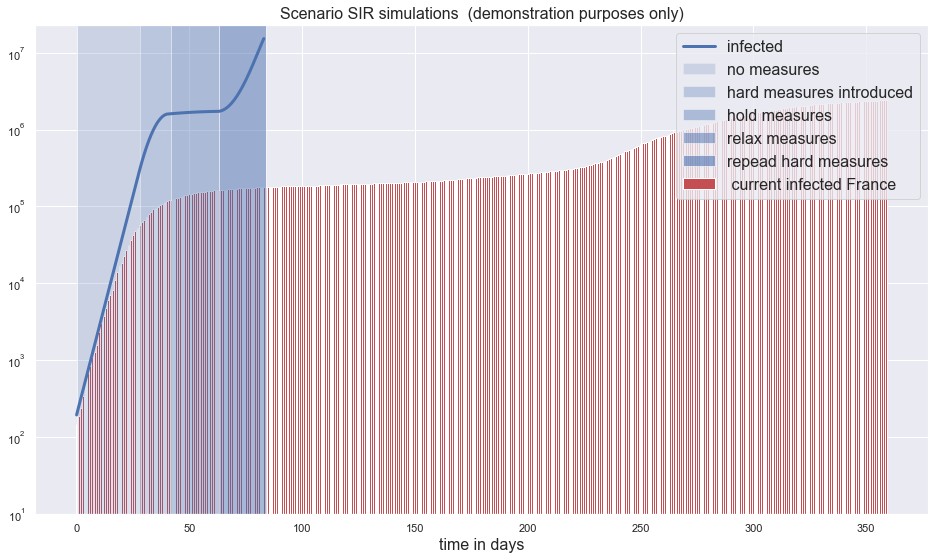

In [22]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',linewidth=3)

t_phases=np.array([t_initial,t_intro_measures,t_hold,t_relax]).cumsum()
ax1.bar(np.arange(len(ydata)),ydata, width=0.8,label=' current infected France',color='r')
ax1.axvspan(0,t_phases[0], facecolor='b', alpha=0.2,label='no measures')
ax1.axvspan(t_phases[0],t_phases[1], facecolor='b', alpha=0.3,label='hard measures introduced')
ax1.axvspan(t_phases[1],t_phases[2], facecolor='b', alpha=0.4,label='hold measures')
ax1.axvspan(t_phases[2],t_phases[3], facecolor='b', alpha=0.5,label='relax measures')
ax1.axvspan(t_phases[3],len(propagation_rates.infected), facecolor='b', alpha=0.6,label='repead hard measures')

ax1.set_ylim(10, 1.5*max(propagation_rates.infected))
ax1.set_yscale('log')
ax1.set_title('Scenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

# Dynamic Data for whole Data Set

In [23]:
data_path=r"D:\SEM 4\Data Science\ads_covid-19\data\raw\COVID-19\csse_covid_19_data\csse_covid_19_time_series\time_series_covid19_confirmed_global.csv"
data_pop = r"D:\SEM 4\Data Science\ads_covid-19\data\raw\COVID-19\csse_covid_19_data\population.csv"

In [24]:
pd_raw = pd.read_csv(data_path)
pd_pop = pd.read_csv(data_pop)
country_list = pd_raw['Country/Region'].unique()
date=pd_raw.columns[4:]
df_analyse=pd.DataFrame({'Date':date})

for each in country_list:
    df_analyse[each] = np.array(pd_raw[pd_raw['Country/Region']==each].iloc[:,4::].sum(axis=0)).T
df_analyse.to_csv('../data/raw/COVID-19/csse_covid_19_data/SIR.csv',index=False)

df_analyse.sort_values('Date',ascending=True).head()
a=list(pd_pop['Pop'])

In [25]:
# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=1000000 #max susceptible population as shown in the lecture taken random
beta=0.4   # infection spread dynamic
gamma=0.1  # recovery rate

df_data=df_analyse[35:]
t=np.arange(df_data.shape[0])
# condition I0+S0+R0=N0

R0=0

#for i in a:
    
#    N0=int(i)
    
for country in df_data.columns[1:]:
    y_data=np.array(df_data[df_data[country]>0][country])
    t=np.arange(len(y_data))

    I0=y_data[0]
    S0=N0-I0
    popt=[0.4,0.1]
    fit_odeint(t, *popt)
    popt, pcov = optimize.curve_fit(fit_odeint, t, y_data, maxfev=5000)
    perr = np.sqrt(np.diag(pcov))
    fitted=fit_odeint(t, *popt)
    fitted_pad = np.concatenate((np.zeros(df_data.shape[0]-len(fitted)) ,fitted))
    df_data[country + '_fitted'] = fitted_pad

df_data = df_data.reset_index(drop=True)
df_data.to_csv(r"D:\SEM 4\Data Science\ads_covid-19\data\processed\SIR_fitted_curve.csv")
    
    

C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-7-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-7-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-7-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-25-3e28ec607d12>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

<ipython-input-25-3e28ec607d12>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[country + '_fitted'] = fitted_pad
C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-7-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-7-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-7-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\Surabhi\anaconda

<ipython-input-25-3e28ec607d12>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[country + '_fitted'] = fitted_pad
C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-7-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-7-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-7-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\Surabhi\anaconda

<ipython-input-25-3e28ec607d12>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[country + '_fitted'] = fitted_pad
C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-7-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-7-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-7-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\Surabhi\anaconda

<ipython-input-7-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-7-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-7-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-25-3e28ec607d12>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[country + '_fitted'] = fitted_pad
C:\Users\Surabhi\anaconda3\lib\site-packa

<ipython-input-25-3e28ec607d12>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[country + '_fitted'] = fitted_pad
C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-7-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-7-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-7-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\Surabhi\anaconda

<ipython-input-25-3e28ec607d12>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[country + '_fitted'] = fitted_pad
<ipython-input-7-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-7-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-7-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-25-3e28ec607d12>:30: Setti

<ipython-input-7-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-7-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-7-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-25-3e28ec607d12>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[country + '_fitted'] = fitted_pad
C:\Users\Surabhi\anaconda3\lib\site-packa

<ipython-input-7-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-7-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-25-3e28ec607d12>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[country + '_fitted'] = fitted_pad
C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type)

C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-7-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-7-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-7-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-25-3e28ec607d12>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

<ipython-input-7-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-7-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-7-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-25-3e28ec607d12>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[country + '_fitted'] = fitted_pad
C:\Users\Surabhi\anaconda3\lib\site-packa

<ipython-input-7-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-7-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-7-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-25-3e28ec607d12>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[country + '_fitted'] = fitted_pad
C:\Users\Surabhi\anaconda3\lib\site-packa

C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-7-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-7-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-7-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-25-3e28ec607d12>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

<ipython-input-7-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-7-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-7-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-25-3e28ec607d12>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[country + '_fitted'] = fitted_pad
C:\Users\Surabhi\anaconda3\lib\site-packa

<ipython-input-7-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-7-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-7-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-25-3e28ec607d12>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[country + '_fitted'] = fitted_pad
C:\Users\Surabhi\anaconda3\lib\site-packa

<ipython-input-25-3e28ec607d12>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[country + '_fitted'] = fitted_pad
<ipython-input-7-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-7-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-7-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-25-3e28ec607d12>:30: Setti

<ipython-input-7-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-7-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-7-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-25-3e28ec607d12>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[country + '_fitted'] = fitted_pad
C:\Users\Surabhi\anaconda3\lib\site-packa

<ipython-input-7-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-7-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-7-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-25-3e28ec607d12>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[country + '_fitted'] = fitted_pad
C:\Users\Surabhi\anaconda3\lib\site-packa

<ipython-input-25-3e28ec607d12>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[country + '_fitted'] = fitted_pad
C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-7-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-7-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-7-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\Surabhi\anaconda

<ipython-input-7-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-7-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-7-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-25-3e28ec607d12>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[country + '_fitted'] = fitted_pad
C:\Users\Surabhi\anaconda3\lib\site-packa

<ipython-input-7-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-7-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-7-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\Surabhi\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-25-3e28ec607d12>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[country + '_fitted'] = fitted_pad
<ipython-input-7-16f200073f8a>:16: Runtim

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.

In [26]:
color_list = []
for i in range(200):
    var = '#%02x%02x%02x'%(random.randint(0,255),random.randint(0,255),random.randint(0,255))
    color_list.append(var)

In [ ]:
# creating dashboard app containig plotting of source and fitted SIR curve data for whole dataset
fig = go.Figure()
app = dash.Dash()
app.layout = html.Div([

    dcc.Markdown('''
    #  Data Science SIR Modelling
    
    * This dashboard plots two curves for each country:
    
    The first curve represents the confirmed infected cases along the timeline.
    The second curve represents the simulated infected cases after applying the SIR model along the timeline. 
    
    '''),

    dcc.Markdown('''
    ## Multi-Select Country for visualization from the dropdown
    '''),
    dcc.Dropdown(
        id='country_drop_down',
        options=[ {'label': each,'value':each} for each in df_data.columns[1:200]],
        value=['India','France', 'Germany'], # which are pre-selected
        multi=True),
    dcc.Graph(figure=fig, id='main_window_slope')])


@app.callback(
    Output('main_window_slope', 'figure'),
    [Input('country_drop_down', 'value')])
def update_figure(country_list):
    v = 0
    my_yaxis={'type':"log",'title':'Infected people'}
    traces = []
    for each in country_list:
        traces.append(dict(x=df_data['Date'],y=df_data[each],
                                mode='line', line = dict(color = color_list[v]), opacity=1.0,name=each))
        traces.append(dict(x=df_data['Date'],
                                y=df_data[each+'_fitted'],
                                mode='lines+markers',line = dict(color=color_list[v]), opacity=1.0,name=each+'_simulated'))

        v = v+1
    return {
            'data': traces,
            'layout': dict (
                width=1280,height=720,
                xaxis={'title':'Timeline','tickangle':-45,'nticks':20,
                'tickfont':dict(size=14,color="#0c6887"),},yaxis=my_yaxis)}

if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)

Running on http://127.0.0.1:8050/
Debugger PIN: 383-432-443
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
